In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
from datasets import load_dataset

from peft import AutoPeftModelForCausalLM

def load_io_dataset(split):
    data_files = []
    data_files.append(f"TTE_with_IO_{split}.json")
    dataset = load_dataset("json", data_files=f"TTE_with_IO_{split}.json")

    def format_example(example):
        return {
            "text": f"Prompt: {example['input']}\nResponse: {example['output']}\n"
        }

    dataset = dataset["train"].map(format_example)
    return dataset

train_dataset = load_io_dataset("train")
test_dataset = load_io_dataset("test")
eval_dataset = load_io_dataset("eval")
print(train_dataset)
print(test_dataset)
print(eval_dataset)



#model_name = "./fine_tuned_qwen3-4b/checkpoint-277"
#model_name = "./fine_tuned_adapters_qwen3-4b"
model_name = "./LA-Framework/results/quantized_model/FT_Qwen3-4B"

# load the tokenizer and the model

inference_model = AutoPeftModelForCausalLM.from_pretrained(
    model_name,
    device_map="cuda",
    #torch_dtype=torch.bfloat16
)

model_name = "../Qwen/models--Qwen--Qwen3-4B/snapshots/1cfa9a7208912126459214e8b04321603b3df60c"

tokenizer = AutoTokenizer.from_pretrained(model_name)

#print(tokenizer)

Dataset({
    features: ['input', 'output', 'text'],
    num_rows: 4430
})
Dataset({
    features: ['input', 'output', 'text'],
    num_rows: 4430
})
Dataset({
    features: ['input', 'output', 'text'],
    num_rows: 4430
})


Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

In [3]:
prompt = eval_dataset[1]['input']
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
output = inference_model.generate(**inputs, max_new_tokens=600)
print(tokenizer.decode(output[0], skip_special_tokens=True))

Based on the user's watching history and the film's rating, order the 50 candidate films. Order the films where the first one of the list is the most likely to be watched by the user. The output should only contain the ordered list of the recommended films bounded by the  special strings '%% START RECOMMENDED LIST %%' and '%% END LIST %%'. Here follows the user's history and the list of candidate films.
%% START HISTORY %%
Movie name: Payback (1999)	Rating:3
Movie name: Under Siege (1992)	Rating:3
Movie name: Independence Day (ID4) (1996)	Rating:3
Movie name: Double Jeopardy (1999)	Rating:3
Movie name: Maverick (1994)	Rating:4
Movie name: Man in the Iron Mask, The (1998)	Rating:3
Movie name: Die Hard: With a Vengeance (1995)	Rating:3
Movie name: Getaway, The (1994)	Rating:3
Movie name: Demolition Man (1993)	Rating:3
Movie name: Conspiracy Theory (1997)	Rating:3
%% END HISTORY %%
%% START CANDIDATES %%
Movie name: Them! (1954)
Movie name: Penitentiary II (1982)
Movie name: Life and Time

In [39]:
import torch
from tqdm.auto import tqdm   # optional, for nicer progress


def split_list(text, start_token, end_token):
    phrase = text.split(start_token + "\n")
    movie_list = phrase[1].split("\n" + end_token)[0]
    movie_list = movie_list.split("\n")
    for i, movie in enumerate(movie_list):
        movie_list[i] = movie.split("\t")
    return movie_list


def perform_and_return_comparison(sample):
    #prompt = sample['text']
    inputs = tokenizer(sample['input'], return_tensors="pt").to("cuda")
    while True:
        output = inference_model.generate(**inputs, max_new_tokens=600)
        rating = tokenizer.decode(output[0], skip_special_tokens=True)
        if ("%% START RECOMMENDED LIST %%\n" in rating):
            break
    
    rating = split_list(rating, "%% START RECOMMENDED LIST %%", "%% END LIST %%")
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    return {'input': sample['input'],
            'rating': rating}

In [ ]:
####   Parallel evaluation code:

In [5]:
import torch
from tqdm.auto import tqdm   # optional, for nicer progress

# Parallel LLM generation of evaluation's results

def perform_and_return_comparison_batched(batch):
    # batch is a dict with lists: {'input': [...], 'text': [...]}
    inputs = tokenizer(
        batch['input'],
        return_tensors="pt",padding=True,
        truncation=True,
        max_length=1024,  # ← set sensible value, e.g. 2048
        padding_side='left'
    ).to("cuda")

    with torch.inference_mode():           # saves a bit of memory
        outputs = inference_model.generate(
            **inputs,
            max_new_tokens=600
        )

    decoded = tokenizer.batch_decode(
        outputs,
        skip_special_tokens=True
    )

    results = []
    for i, rating_full in enumerate(decoded):
        rating = split_list(
            rating_full,
            "%% START RECOMMENDED LIST %%",
            "%% END LIST %%"
        )
        results.append({
            'input': batch['input'][i],
            'rating': rating
        })

    return {'results': results}   # list of dicts — datasets will flatten it

# This is usually enough parallelism for one GPU
eval_output = eval_dataset.map(
    perform_and_return_comparison_batched,
    batched=True,
    batch_size=8,          # ← tune this: 4–16 most common sweet spot
                           # larger = better GPU util, but risk of OOM
    desc="Evaluating",
    remove_columns=eval_dataset.column_names,  # optional — keep only new fields
)

eval_output.to_json("peft_quantized_eval_processed_parallel.json")

Evaluating:   0%|          | 0/4430 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

19514488

In [ ]:
####   Run from here next

In [70]:
import pandas as pd

llm_results = pd.read_json(f"peft_quantized_eval_processed_parallel.json", lines=True)
#print(llm_results.iloc[0]['results']['input'])
llm_results['results'] = [[[movie[0].removeprefix("Movie name: ")] for movie in m_list['rating']] for m_list in llm_results['results']]
print(llm_results.iloc[0]['results'])

eval_dataset = pd.read_json(f"TTE_with_IO_eval.json")
#print(eval_dataset.iloc[0]['input'])
#print(eval_dataset.iloc[0]['output'])

def split_list(text, start_token, end_token):
    phrase = text.split(start_token + "\n")
    movie_list = phrase[1].split("\n" + end_token)[0]
    movie_list = movie_list.split("\n")
    for i, movie in enumerate(movie_list):
        movie_list[i] = movie.split("\t")
    return movie_list

eval_dataset['user_out_list'] = [split_list(x, "%% START RECOMMENDED LIST %%", "%% END LIST %%") for x in eval_dataset['output']]
eval_dataset['user_out_list'] = [[[movie[0].removeprefix("Movie name: ")] for movie in m_list] for m_list in eval_dataset['user_out_list']]
print(eval_dataset.iloc[0]['user_out_list'])

pd_data = pd.DataFrame()
pd_data["sorted_candidates"] = eval_dataset['user_out_list']
pd_data["relevant_movies"] = pd_data["sorted_candidates"].apply(lambda data: data[:10])
pd_data["sorted_rating"] = llm_results['results']
print(pd_data.head(1))



[['Tarzan (1999)'], ['Close Shave, A (1995)'], ['Antz (1998)'], ['Hunchback of Notre Dame, The (1996)'], ['Hercules (1997)'], ['Mulan (1998)'], ['Beauty and the Beast (1991)'], ['Toy Story (1995)'], ['Antz (1998)'], ["Bug's Life, A (1998)"], ['Toy Story 2 (1999)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['Antz (1998)'], ['%% END RECOMMENDED LIST %%'], ['The user\'s watching history includes several animated

In [71]:
print(pd_data["sorted_rating"].apply(len))

np_array = pd_data["sorted_rating"].apply(len).values
total = sum([1 if x<10 else 0 for x in np_array])
print(total)

0       51
1       10
2       20
3       43
4       10
        ..
4425    48
4426    47
4427    10
4428    35
4429    48
Name: sorted_rating, Length: 4430, dtype: int64
300


In [ ]:
"""
np_array = pd_data["sorted_rating"].apply(len).values
print(np_array)
total = sum([1 if x<10 else 0 for x in np_array])
print(total)
mask = np_array < 10
print(mask)
pd_data["fixed_res"] = pd_data["sorted_rating"]
print()

count = 0
for i in range(len(eval_dataset)):
    if mask[i]:
        count += 1
        m_list = perform_and_return_comparison(eval_dataset.iloc[i])
        pd_data["fixed_res"][i] = [[movie[0].removeprefix("Movie name: ")] for movie in m_list['rating']]
        print(f"\rExecuted: {count}/{total}")
"""

In [72]:
def correct_list(list_of_films):
    if len(list_of_films) < 10:
        new_list = list_of_films
        while len(new_list)<10 :
            new_list.append([""])
        return new_list
    else:
        return list_of_films

pd_data["sorted_rating"] = pd_data["sorted_rating"].apply(correct_list)


In [73]:
from tabulate import tabulate
import math

avgs = [[0 for n_rel in range(10)] for k_i in [1,5,10]]

for k_i in [1,5,10]:
    for n_rel in range(10):
        
        def hit_rate_at_k(predicted_ranking, relevant_items, k):
            top_k = set(predicted_ranking[:k])
            return 1 if top_k.intersection(relevant_items[:n_rel+1]) else 0
        
        def hit_rate_for_row(row):
            ratings = [movie for [movie] in row['sorted_rating']]
            rel_item = [movie for [movie] in row["relevant_movies"]]
            return hit_rate_at_k(ratings, rel_item, k_i)
        
        pd_data["hit_rate"] = pd_data.apply(hit_rate_for_row, axis=1)
        avg = pd_data["hit_rate"].mean()
        avgs[int(k_i/5)][n_rel] = math.trunc(avg * 10_000) / 10_000
        # print(avg)

# print(avgs)

print(tabulate(
    avgs,
    headers=[f"#RI {n+1}" for n in range(10)],
    showindex=[f"HitRate@{k}" for k in [1,5,10]],
    tablefmt="grid"
))

+------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+
|            |   #RI 1 |   #RI 2 |   #RI 3 |   #RI 4 |   #RI 5 |   #RI 6 |   #RI 7 |   #RI 8 |   #RI 9 |   #RI 10 |
+============+=========+=========+=========+=========+=========+=========+=========+=========+=========+==========+
| HitRate@1  |  0.7489 |  0.8063 |  0.8063 |  0.8063 |  0.8063 |  0.8148 |  0.8148 |  0.8148 |  0.8155 |   0.8158 |
+------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+
| HitRate@5  |  0.7693 |  0.9065 |  0.932  |  0.9322 |  0.9322 |  0.9322 |  0.9322 |  0.9322 |  0.9322 |   0.9322 |
+------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+
| HitRate@10 |  0.8595 |  0.9275 |  0.932  |  0.9322 |  0.9322 |  0.9322 |  0.9322 |  0.9322 |  0.9322 |   0.9322 |
+------------+---------+---------+---------+---------+---------+--------

In [75]:
import numpy as np

def dcg_at_k(relevances, k):
    relevances = np.array(relevances[:k])
    return np.sum(relevances / np.log2(np.arange(2, k + 2)))

def ndcg_at_k(predicted_ranking, relevance_dict, k):
    rel_pred = [relevance_dict.get(item, 0) for item in predicted_ranking]
    dcg = dcg_at_k(rel_pred, k)
    ideal_rel = sorted(relevance_dict.values(), reverse=True)
    idcg = dcg_at_k(ideal_rel, k)
    return dcg / idcg if idcg > 0 else 0

def ndcg_for_row(row):
    predicted = [movie for [movie] in row['sorted_rating']]
    relevance_dict = {movie:1 for [movie] in row["sorted_candidates"]}  # Others default to 0
    k = 10
    ndcg = ndcg_at_k(predicted, relevance_dict, k)
    return ndcg

pd_data["ndcg"] = pd_data.apply(ndcg_for_row, axis=1)

#ndcg_for_row(pd_data.loc[0])
print(pd_data.head(1))
avg = pd_data["ndcg"].mean()
print(avg)

                                   sorted_candidates  \
0  [[Tarzan (1999)], [Close Shave, A (1995)], [An...   

                                     relevant_movies  \
0  [[Tarzan (1999)], [Close Shave, A (1995)], [An...   

                                       sorted_rating  hit_rate  ndcg  
0  [[Tarzan (1999)], [Close Shave, A (1995)], [An...         1   1.0  
0.9156586122548529


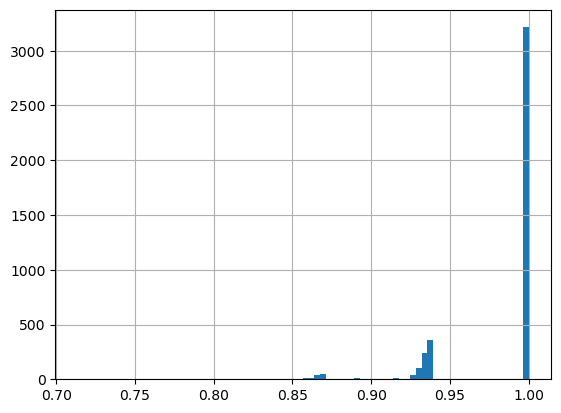

In [79]:
import matplotlib.pyplot as plt

(pd_data[pd_data['ndcg'] > 0])['ndcg'].hist(bins=80)
#pd_data['ndcg'].hist(bins=80)
plt.show()